<a href="https://colab.research.google.com/github/Adonis-Waffo/NLP_Adonis/blob/main/MTN_Cameroon_Sentimeter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textblob
!pip install textblob-fr
!pip install flair
!pip install apify-client
!pip install wordcloud
!pip install plotly
!python -m spacy download fr_core_news_sm
#!python -m textblob.download_corpora fr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 33.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
#Importation des packages

from flair.models import TextClassifier
from flair.data import Sentence
from apify_client import ApifyClient
import pandas as pd
from google.colab import drive
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
import plotly.graph_objects as go
from textblob_fr import PatternTagger, PatternAnalyzer
import plotly.express as px
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import spacy


nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


from collections import Counter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
### recuperer les Posts de la page Facebook de MTN Cameroon ###
### Ces données seront conservée dans un fichier csv ###
# Initialisation du client ApifyClient avec mon TOKEN
client = ApifyClient("apify_api_Gd4NcPawacbnj54a1XDc8fpwbz9MgX3zoald")

# Je prepare les paramètres de ma requètes.
#l'url de la page facebook de MTN Cameroon
#Le nombre de Post Facebook a Scraper
run_input = {
    "startUrls": [{ "url": "https://web.facebook.com/MTNCAMEROON?locale=fr_FR" }],
    "resultsLimit": 250,
}

# Exécution de l'appel API
run = client.actor("KoJrdxJCTtpon81KY").call(run_input=run_input)

In [ ]:
# Récupération des résultats depuis le dataset
data = list(client.dataset(run["defaultDatasetId"]).iterate_items())
# Conversion en DataFrame
df = pd.DataFrame(data)

# On ne recupere que ce qui est interessant pour le projet
new_df = df[['postId', 'url','time','text','likes','comments','shares']]
###On sauvegarde le Les Posts que l'on a scrapé directement dans Google Drive
drive.mount('/content/drive')
new_df.to_csv('/content/drive/My Drive/Master 1 AI/Projet fin Informatique/facebook_posts.csv', index=False)

Mounted at /content/drive


In [ ]:
### recuperer les Commentaires sous les posts de la page Facebook de MTN Cameroon ###
### Ces données seront conservée dans un fichier csv ###
#On commence par recuperer les Posts dans un Data frame
Fb_Post_df=pd.read_csv("/content/drive/My Drive/Master 1 AI/Projet fin Informatique/facebook_posts.csv")
Posts_comments_df = pd.DataFrame()#on cree un dataFrame vide

# Initialisation du client ApifyClient avec mon un autre TOKEN le précédent n'etant plus gratuit
client = ApifyClient("apify_api_6kLWE1tt1P5j9agbqZkJV3PHXAr74i2ry6FB")

#Pour chaque Post, on va recupérer au plus 100 commentaires
for index, row in Fb_Post_df.iterrows():
  # on prepare les paramètres de l'appel API
  run_input = {
      "startUrls": [{ "url": row['url']}],
      "resultsLimit": 100,
      "includeNestedComments": False,
      "viewOption": "RANKED_UNFILTERED",
  }
  #On exécute l'appel de l'API
  run_comments = client.actor("us5srxAYnsrkgUv2v").call(run_input=run_input)
  # Récupération des résultats depuis le dataset
  data = list(client.dataset(run_comments["defaultDatasetId"]).iterate_items())
  # Conversion en DataFrame et ajout dans Posts_comments_df
  Posts_comments_df = pd.concat([Posts_comments_df, pd.DataFrame(data)]).reset_index(drop = True)


In [ ]:
###On sauvegarde le Les Commentaires que l'on a scrapé directement dans Google Drive
drive.mount('/content/drive')
Posts_comments_df.to_csv('/content/drive/My Drive/Master 1 AI/Projet fin Informatique/facebook_Comments.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### On recupère nos commentaires:
Fb_Comments_df=pd.read_csv("/content/drive/My Drive/Master 1 AI/Projet fin Informatique/facebook_Comments.csv")
Fb_Comments_df.head()

,facebookUrl,commentUrl,id,feedbackId,date,text,profileUrl,profilePicture,profileId,profileName,...,threadingDepth,facebookId,postTitle,pageAdLibrary,inputUrl,commentsCount,comments,attachments,error,errorDescription
0,https://www.facebook.com/MTNCAMEROON/posts/pfb...,https://www.facebook.com/MTNCAMEROON/posts/pfb...,Y29tbWVudDoxMDEwNjYzMTk0NDM2NjQ4XzM3NjI4NDg2NT...,ZmVlZGJhY2s6MTAxMDY2MzE5NDQzNjY0OF8zNzYyODQ4Nj...,2024-11-26T07:00:17.000Z,Yes yes,https://www.facebook.com/paule.leharnier,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,pfbid02XxLKcv8ZwkR3jg1CFx17hwZ96fHGpzEkGX5SVqf...,Diane Cassidy,...,0.0,1.010663e+15,Y’ello !\nQuand tu vois une semaine qui va réu...,"{'is_business_page_active': False, 'id': '1755...",https://www.facebook.com/MTNCAMEROON/posts/pfb...,NaN,NaN,NaN,NaN,NaN
1,https://www.facebook.com/MTNCAMEROON/posts/pfb...,https://www.facebook.com/MTNCAMEROON/posts/pfb...,Y29tbWVudDoxMDEwNjYzMTk0NDM2NjQ4XzkyOTU3ODgwMT...,ZmVlZGJhY2s6MTAxMDY2MzE5NDQzNjY0OF85Mjk1Nzg4MD...,2024-11-26T07:12:17.000Z,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,https://www.facebook.com/sadou.galdi,https://scontent-iad3-1.xx.fbcdn.net/v/t1.6435...,pfbid0Y23k72h4wZzUPVGDS6fsAJzP2VUsbtaZkmozpQar...,Abbo Sadou Galdi,...,0.0,1.010663e+15,Y’ello !\nQuand tu vois une semaine qui va réu...,"{'is_business_page_active': False, 'id': '1755...",https://www.facebook.com/MTNCAMEROON/posts/pfb...,NaN,NaN,NaN,NaN,NaN
2,https://www.facebook.com/MTNCAMEROON/posts/pfb...,https://www.facebook.com/MTNCAMEROON/posts/pfb...,Y29tbWVudDoxMDEwNjYzMTk0NDM2NjQ4XzM5MDE2MTQ2MD...,ZmVlZGJhY2s6MTAxMDY2MzE5NDQzNjY0OF8zOTAxNjE0Nj...,2024-11-26T07:09:04.000Z,Super🫶,https://www.facebook.com/people/Kalana-Abel-Sc...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,100087916764495,Kalana Abel Schadrak,...,0.0,1.010663e+15,Y’ello !\nQuand tu vois une semaine qui va réu...,"{'is_business_page_active': False, 'id': '1755...",https://www.facebook.com/MTNCAMEROON/posts/pfb...,NaN,NaN,NaN,NaN,NaN
3,https://www.facebook.com/MTNCAMEROON/posts/pfb...,https://www.facebook.com/MTNCAMEROON/posts/pfb...,Y29tbWVudDoxMDEwNjYzMTk0NDM2NjQ4XzM5NzE5MTE4ND...,ZmVlZGJhY2s6MTAxMDY2MzE5NDQzNjY0OF8zOTcxOTExOD...,2024-11-26T06:56:55.000Z,Cool,https://www.facebook.com/people/Larissa-Wanle/...,https://scontent-iad3-2.xx.fbcdn.net/v/t39.308...,pfbid03kawSacNFvbk6v2nUGanr7Wg278EQKy7Dmpjq9oF...,Larissa Wanle,...,0.0,1.010663e+15,Y’ello !\nQuand tu vois une semaine qui va réu...,"{'is_business_page_active': False, 'id': '1755...",https://www.facebook.com/MTNCAMEROON/posts/pfb...,NaN,NaN,NaN,NaN,NaN
4,https://www.facebook.com/MTNCAMEROON/posts/pfb...,https://www.facebook.com/MTNCAMEROON/posts/pfb...,Y29tbWVudDoxMDEwNjYzMTk0NDM2NjQ4XzI3NTgyNTk4NT...,ZmVlZGJhY2s6MTAxMDY2MzE5NDQzNjY0OF8yNzU4MjU5OD...,2024-11-26T07:02:25.000Z,Good,https://www.facebook.com/people/Keith-Caleb-He...,https://scontent-iad3-1.xx.fbcdn.net/v/t39.308...,100076544554777,Keith Caleb Hermann,...,0.0,1.010663e+15,Y’ello !\nQuand tu vois une semaine qui va réu...,"{'is_business_page_active': False, 'id': '1755...",https://www.facebook.com/MTNCAMEROON/posts/pfb...,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Information sur la base des commentaires
Fb_Comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5663 entries, 0 to 5662
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   facebookUrl       5660 non-null   object 
 1   commentUrl        5660 non-null   object 
 2   id                5660 non-null   object 
 3   feedbackId        5660 non-null   object 
 4   date              5660 non-null   object 
 5   text              5503 non-null   object 
 6   profileUrl        5041 non-null   object 
 7   profilePicture    5660 non-null   object 
 8   profileId         5660 non-null   object 
 9   profileName       5660 non-null   object 
 10  likesCount        5660 non-null   float64
 11  threadingDepth    5660 non-null   float64
 12  facebookId        5660 non-null   float64
 13  postTitle         5660 non-null   object 
 14  pageAdLibrary     4034 non-null   object 
 15  inputUrl          5660 non-null   object 
 16  commentsCount     4737 non-null   float64


In [ ]:
#Information sur la base des commentaires
Fb_Comments_df.shape

(5663, 21)

In [ ]:
#Detectction des valeurs manquantes
Fb_Comments_df.isnull().sum()

,0
facebookUrl,3
commentUrl,3
id,3
feedbackId,3
date,3
text,160
profileUrl,622
profilePicture,3
profileId,3
profileName,3


In [ ]:
### Pour notre projet, on va garder uniquement le texte du commentaire, le nombre de like et la date
Fb_Comments_df=Fb_Comments_df[['text','likesCount','date']]
Fb_Comments_df.head()

,text,likesCount,date
0,Yes yes,0.0,2024-11-26T07:00:17.000Z
1,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,0.0,2024-11-26T07:12:17.000Z
2,Super🫶,0.0,2024-11-26T07:09:04.000Z
3,Cool,0.0,2024-11-26T06:56:55.000Z
4,Good,0.0,2024-11-26T07:02:25.000Z


In [ ]:
#Suppression des valeurs manquantes
Fb_Comments_df = Fb_Comments_df.dropna()
Fb_Comments_df.isnull().sum()

,0
text,0
likesCount,0
date,0


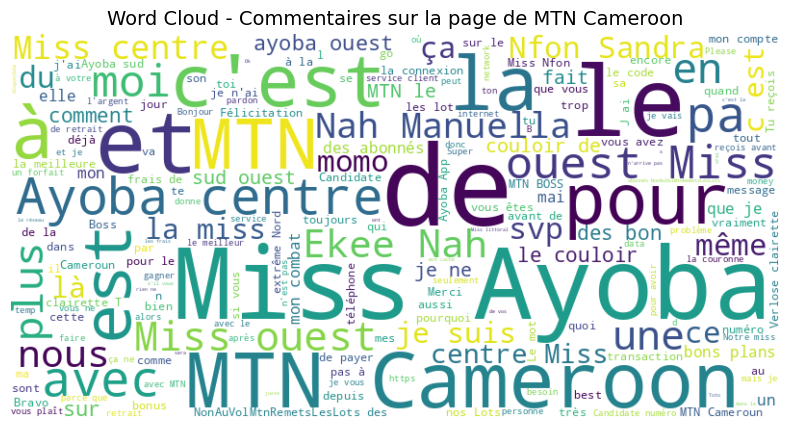

In [ ]:
#### on commence par générer un word Cloud
# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud
generer_wordcloud(Fb_Comments_df['text'], 'Word Cloud - Commentaires sur la page de MTN Cameroon')

In [ ]:
#Nettoyage et construction du pipeline NLP
#On va clean le les commentaires avec Reg-ex (pipeline de nettoyage des données)


def nlp_pipeline(text):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', '')
    text = ' '.join(text.split())
    text = re.sub(r"[A-Za-z\.]*[0-9]+[A-Za-z%°\.]*", "", text)
    text = re.sub(r"(\s\-\s|-$)", "", text)
    text = re.sub(r"[,\!\?\%\(\)\/\"]", "", text)
    text = re.sub(r"\&\S*\s", "", text)
    text = re.sub(r"\&", "", text)
    text = re.sub(r"\+", "", text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"\$", "", text)
    text = re.sub(r"\£", "", text)
    text = re.sub(r"\%", "", text)
    text = re.sub(r"\:", "", text)
    text = re.sub(r"\@", "", text)
    text = re.sub(r"\-", "", text)
    return text

In [ ]:
#On clean nos commentaires Fb
Fb_Comments_df['texte_nettoye'] = Fb_Comments_df['text'].apply(nlp_pipeline)
Fb_Comments_df.head()

,text,likesCount,date,texte_nettoye
0,Yes yes,0.0,2024-11-26T07:00:17.000Z,yes yes
1,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,0.0,2024-11-26T07:12:17.000Z,ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏
2,Super🫶,0.0,2024-11-26T07:09:04.000Z,super🫶
3,Cool,0.0,2024-11-26T06:56:55.000Z,cool
4,Good,0.0,2024-11-26T07:02:25.000Z,good


In [ ]:
###Pré processing des Commentaires Facebook
## On va faire de la lemmatisation ce qui va réduire la complexité des données textuelles en transformant les mots en leur forme canonique,
## ce qui facilite la comparaison, la recherche et l'analyse du texte de manière plus précise

stop_words = stopwords.words('french')

# Charger le modèle français de spacy
#nlp = spacy.load("fr_core_news_sm")

def clean_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    processed_tweet = re.sub(r"[^\w\s]", "", text)

    # Conversion en minuscules
    processed_tweet = processed_tweet.lower()

    # Tokenisation du texte
    tokens = word_tokenize(processed_tweet)

    # Suppression des mots vides
    stop_words = set(stopwords.words("french"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation des tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Joindre les tokens en une seule chaîne
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# Appliquer le nettoyage du texte sur la colonne 'texte'
Fb_Comments_df['texte_nettoye'] = Fb_Comments_df['text'].apply(clean_text)

Fb_Comments_df.head()

,text,likesCount,date,texte_nettoye
0,Yes yes,0.0,2024-11-26T07:00:17.000Z,yes yes
1,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,0.0,2024-11-26T07:12:17.000Z,ok cest note
2,Super🫶,0.0,2024-11-26T07:09:04.000Z,super
3,Cool,0.0,2024-11-26T06:56:55.000Z,cool
4,Good,0.0,2024-11-26T07:02:25.000Z,good


In [ ]:
#stop_words_fr = nlp.Defaults.stop_words
stop_words

['au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'c',
 'd',
 'j',
 'l',
 'à',
 'm',
 'n',
 's',
 't',
 'y',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',


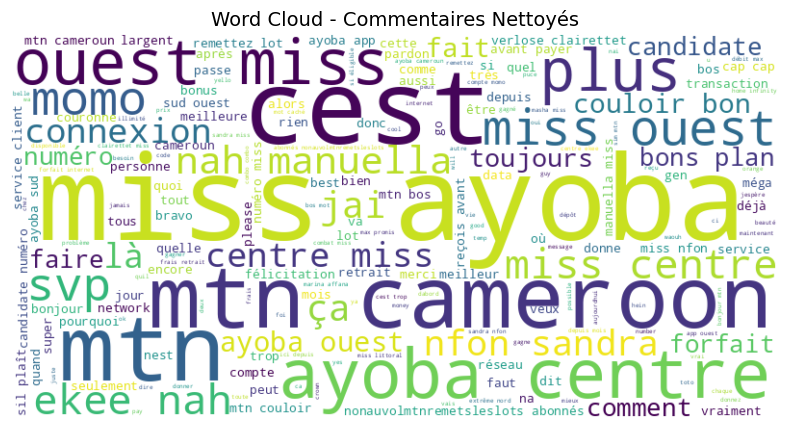

In [ ]:
# Générer le word cloud des données nettoyées
generer_wordcloud(Fb_Comments_df['texte_nettoye'], 'Word Cloud - Commentaires Nettoyés')

In [39]:
#Suppression des chaines vides
Fb_Comments_df = Fb_Comments_df.dropna(subset=['texte_nettoye'])
Fb_Comments_df = Fb_Comments_df[Fb_Comments_df['texte_nettoye'].str.strip() != '']
Fb_Comments_df.head(10)
Fb_Comments_df.shape

(5142, 6)

In [57]:
# Créer une liste pour stocker les sentiments
polarity = []
sentiment = []
classifier = TextClassifier.load("sentiment")

# Parcourir la colonne et ajouter les catégories correspondantes
for texte in Fb_Comments_df['texte_nettoye']:
    #print('texte = '+texte)
    sentence = Sentence(texte)
    classifier.predict(sentence)
    if len(sentence.labels) == 0:
        polarity.append(0)
        sentiment.append('NEUTRAL')
    elif sentence.labels[0].value == "NEGATIVE":
        polarity.append(-sentence.labels[0].score)
        sentiment.append(sentence.labels[0].value)
    else:
      polarity.append(sentence.labels[0].score)
      sentiment.append(sentence.labels[0].value)

# Ajouter les colonnes au DataFrame
Fb_Comments_df['polarity'] = polarity
Fb_Comments_df['sentiment'] = sentiment
Fb_Comments_df.head(10)

,text,likesCount,date,texte_nettoye,polarity,sentiment
0,Yes yes,0.0,2024-11-26,yes yes,0.993386,POSITIVE
1,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,0.0,2024-11-26,ok cest note,-0.940481,NEGATIVE
2,Super🫶,0.0,2024-11-26,super,0.997290,POSITIVE
3,Cool,0.0,2024-11-26,cool,0.989185,POSITIVE
4,Good,0.0,2024-11-26,good,0.931395,POSITIVE
6,Too much,0.0,2024-11-26,too much,-0.997757,NEGATIVE
7,Besoin d'un forfait internet gratuit s'il vous...,0.0,2024-11-26,besoin dun forfait internet gratuit sil plaît,-0.863654,NEGATIVE
8,C'est bien,0.0,2024-11-25,cest bien,-0.633535,NEGATIVE
9,Okay,0.0,2024-11-25,okay,-0.560130,NEGATIVE
10,Depuis que je fais les transactions la j'ai to...,0.0,2024-11-25,depuis fais transaction jai toujours 0 point c...,-0.983882,NEGATIVE


In [40]:
# Calcule de la polarité
#Fb_Comments_df['polarity'] = Fb_Comments_df['texte_nettoye'].apply(lambda x: TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[0])
#Fb_Comments_df['subjectivity'] = Fb_Comments_df['texte_nettoye'].apply(lambda x: TextBlob(x,pos_tagger=PatternTagger(),analyzer=PatternAnalyzer()).sentiment[1])
# Définir les étiquettes de sentiment en fonction de la polarité
#Fb_Comments_df['Sentiment'] = Fb_Comments_df['polarity'].apply(lambda x: 'Positif' if x > 0 else ('Négatif' if x < 0 else 'Neutre'))
#Fb_Comments_df

In [58]:
# On affiche les statistiques de notre dataframe
Fb_Comments_df.describe()

,likesCount,polarity
count,5142.000000,5142.000000
mean,0.234345,0.248851
std,0.836883,0.876714
min,0.000000,-0.999995
25%,0.000000,-0.889615
50%,0.000000,0.834873
75%,0.000000,0.989737
max,19.000000,0.999934


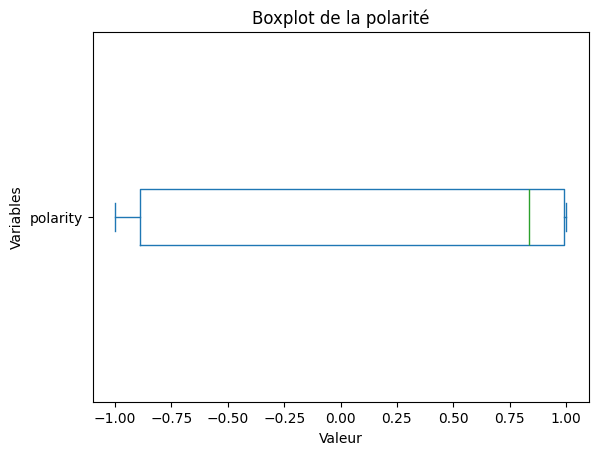

In [59]:
# Tracer le boxplot pour la polarité
Fb_Comments_df[['polarity']].plot(kind='box', vert=False)

# Ajouter des titres et des étiquettes d'axe
plt.title('Boxplot de la polarité')
plt.xlabel('Valeur')
plt.ylabel('Variables')

# Afficher le boxplot
plt.show()

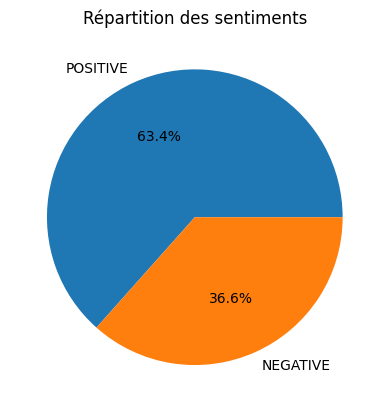

In [60]:
# Compter le nombre de chaque sentiment
sentiment_counts = Fb_Comments_df['sentiment'].value_counts()

# Obtenir les étiquettes de sentiment et les valeurs correspondantes
labels = sentiment_counts.index.tolist()
values = sentiment_counts.values.tolist()

# Tracer le diagramme circulaire
plt.pie(values, labels=labels, autopct='%1.1f%%')

# Ajouter un titre
plt.title("Répartition des sentiments")

# Afficher le diagramme circulaire
plt.show()

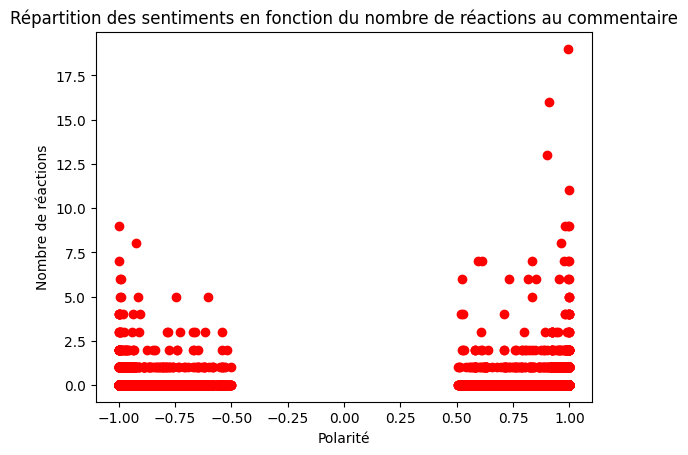

In [61]:

plt.scatter(Fb_Comments_df['polarity'], Fb_Comments_df['likesCount'], color='red')
plt.xlabel('Polarité')
plt.ylabel('Nombre de réactions')
plt.title('Répartition des sentiments en fonction du nombre de réactions au commentaire')
plt.show()

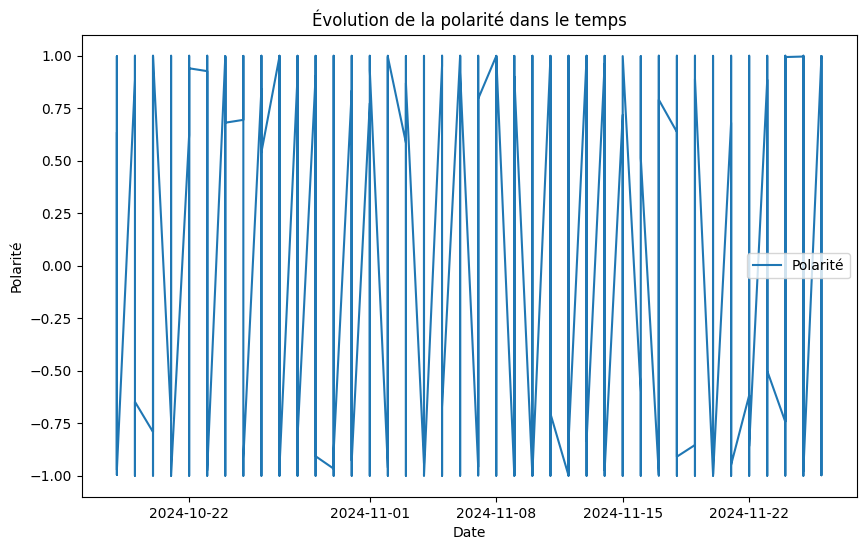

In [62]:
# Convertir la colonne 'Date' en type de données 'datetime'
Fb_Comments_df['date'] = pd.to_datetime(Fb_Comments_df['date'])

# Trier le DataFrame par ordre croissant de dates
df = Fb_Comments_df.sort_values('date')

# Créer la figure et les axes
plt.figure(figsize=(10, 6))

# Tracer la ligne de l'évolution de la polarité
plt.plot(df['date'], df['polarity'], label='Polarité')

# Ajouter un titre et des étiquettes d'axes
plt.title('Évolution de la polarité dans le temps')
plt.xlabel('Date')
plt.ylabel('Polarité')

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()

In [63]:

# Convertir la colonne 'date' en type datetime
Fb_Comments_df['date'] = pd.to_datetime(Fb_Comments_df['date'])

# Enlever les heures de la date
Fb_Comments_df['date'] = Fb_Comments_df['date'].dt.date
# Calculer le nombre de tweets par sentiment et par date
df_agg = Fb_Comments_df.groupby(['date', 'sentiment']).size().reset_index(name='counts')

df_agg.head()

,date,sentiment,counts
0,2024-10-18,NEGATIVE,2
1,2024-10-18,POSITIVE,4
2,2024-10-19,NEGATIVE,44
3,2024-10-19,POSITIVE,108
4,2024-10-20,NEGATIVE,31


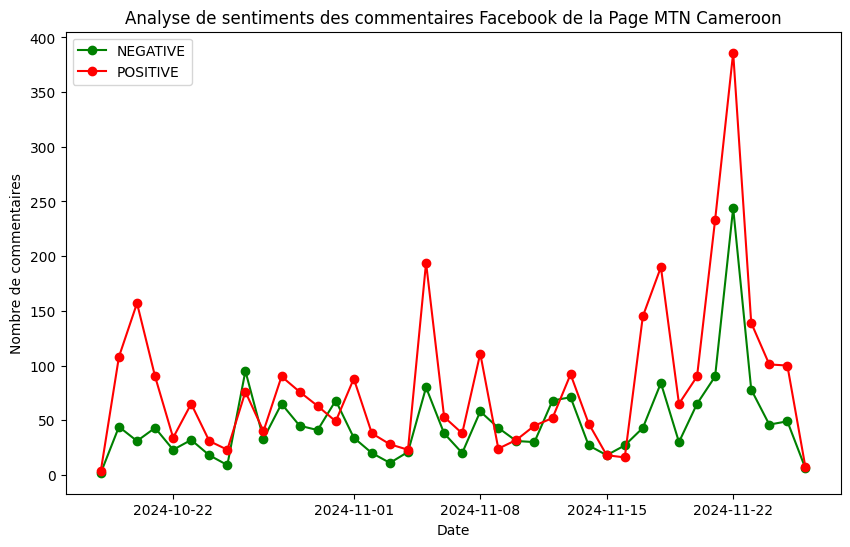

In [64]:
# Créer une figure et des axes
fig, ax = plt.subplots(figsize=(10, 6))

# Grouper les données par Sentiment et créer une liste de couleurs
groups = df_agg.groupby('sentiment')
colors = ['blue', 'red', 'green']  # Ajuster les couleurs selon vos besoins

# Tracer les lignes pour chaque groupe de Sentiment
for name, group in groups:
    ax.plot(group['date'], group['counts'], marker='o', label=name, color=colors.pop())

# Ajouter un titre et des étiquettes d'axes
ax.set_title('Analyse de sentiments des commentaires Facebook de la Page MTN Cameroon')
ax.set_xlabel('Date')
ax.set_ylabel('Nombre de commentaires')

# Afficher la légende
ax.legend()

# Afficher le graphique
plt.show()

In [65]:
# Grouper par date et compter le nombre de sentiments positifs, négatifs et neutres par journée
sentiment_counts = Fb_Comments_df.groupby('date')['sentiment'].value_counts().unstack().fillna(0)

# Afficher le résultat
print(sentiment_counts)

sentiment   NEGATIVE  POSITIVE
date                          
2024-10-18         2         4
2024-10-19        44       108
2024-10-20        31       157
2024-10-21        43        90
2024-10-22        23        34
2024-10-23        32        65
2024-10-24        18        31
2024-10-25         9        23
2024-10-26        95        76
2024-10-27        33        40
2024-10-28        65        90
2024-10-29        45        76
2024-10-30        41        63
2024-10-31        68        49
2024-11-01        34        88
2024-11-02        20        38
2024-11-03        11        28
2024-11-04        21        23
2024-11-05        80       194
2024-11-06        38        53
2024-11-07        20        38
2024-11-08        58       111
2024-11-09        43        24
2024-11-10        31        32
2024-11-11        30        45
2024-11-12        68        52
2024-11-13        71        92
2024-11-14        27        47
2024-11-15        18        18
2024-11-16        27        16
2024-11-

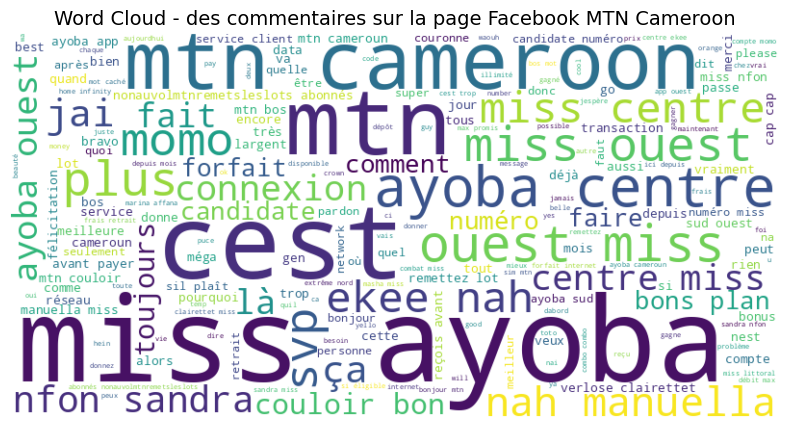

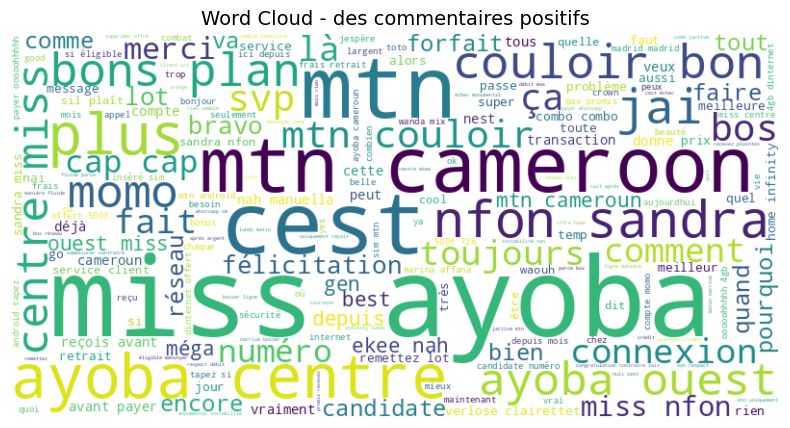

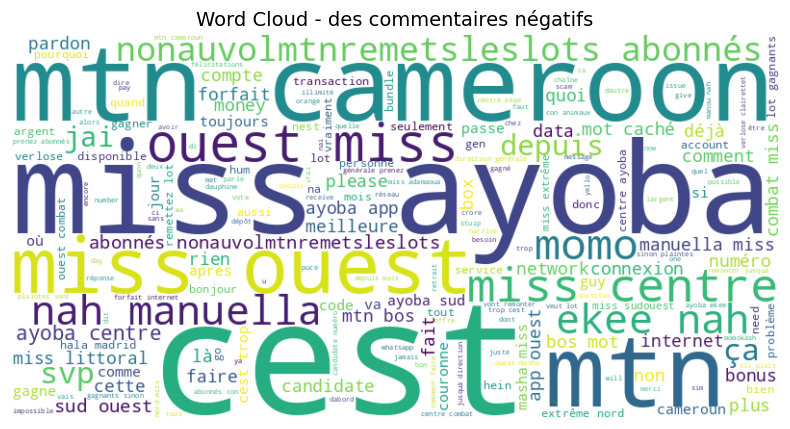

There are no neutral comments to generate a word cloud.


In [67]:
# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(Fb_Comments_df['texte_nettoye'], 'Word Cloud - des commentaires sur la page Facebook MTN Cameroon')
# Filtrer les commentaires positifs
commentaires_positifs = Fb_Comments_df[Fb_Comments_df['polarity']>0]['texte_nettoye']
generer_wordcloud(commentaires_positifs, 'Word Cloud - des commentaires positifs')
# Filtrer les commentaires positifs
commentaires_negatifs = Fb_Comments_df[Fb_Comments_df['polarity'] < 0]['texte_nettoye']
generer_wordcloud(commentaires_negatifs, 'Word Cloud - des commentaires négatifs')
# Filtrer les commentaires positifs
commentaires_neutre = Fb_Comments_df[Fb_Comments_df['polarity'] ==0]['texte_nettoye']
if len(commentaires_neutre) > 0:  # Check if there are any neutral comments
    generer_wordcloud(commentaires_neutre, 'Word Cloud - des commentaires neutres')
else:
    print("There are no neutral comments to generate a word cloud.")


In [68]:
# Breaking down the comments into words in seperate categories
positive_tokens = [token for line in commentaires_positifs for token in line.split()]
negative_tokens = [token for line in commentaires_negatifs for token in line.split()]
neutral_tokens = [token for line in commentaires_neutre for token in line.split()]

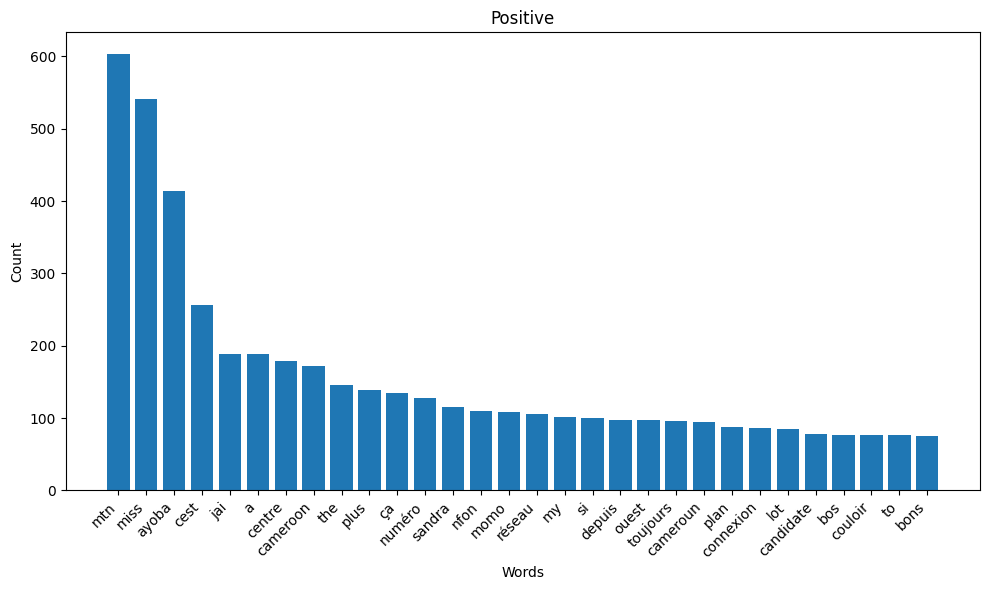

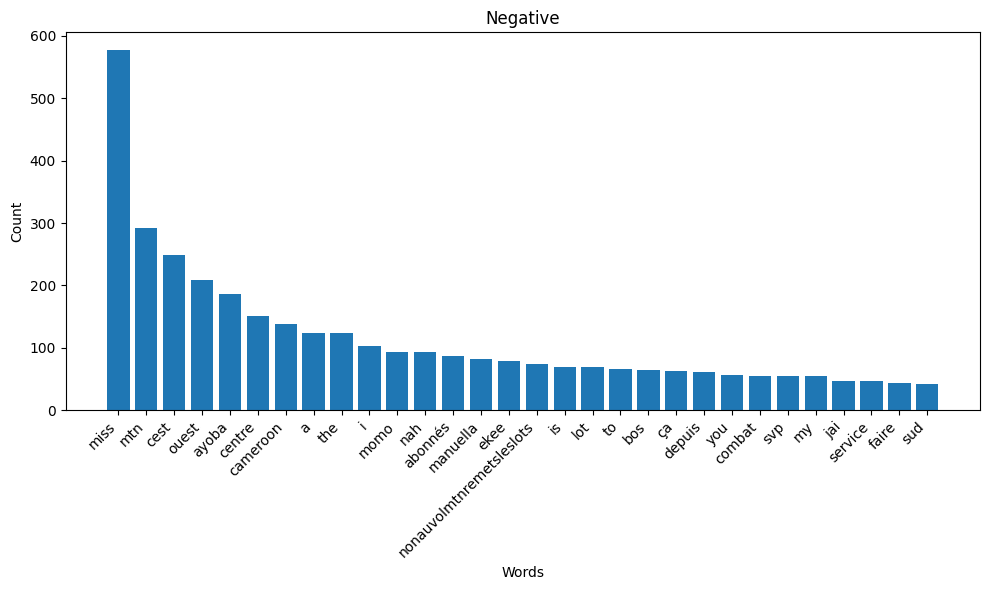

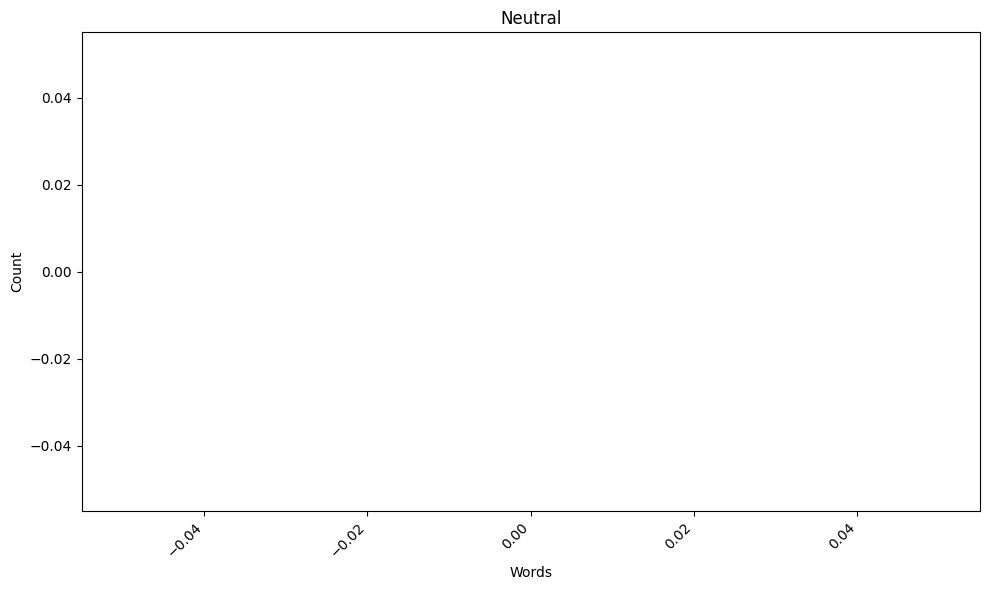

In [69]:

# pour obtenir les mots les plus utilisés
def get_maxtoken(comments, num=30):
  word_tokens = Counter(comments)
  max_common = word_tokens.most_common(num)
  return dict(max_common)

def token_df_vis_matplotlib(x, title):

    # on prend le max token
    df = pd.DataFrame(get_maxtoken(x).items(), columns=['words', 'count'])
    #print(df)
    # on créé les barre du chart
    plt.figure(figsize=(10, 6))
    plt.bar(df['words'], df['count'])
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

token_df_vis_matplotlib(positive_tokens,'Positive')
token_df_vis_matplotlib(negative_tokens,'Negative')
token_df_vis_matplotlib(neutral_tokens,'Neutral')

In [94]:
#### Essayons maintenant d'analyser les commentaires en relation avec les deux dernières campagnes Marketing de MTN Cameroon
####(La Finale des Miss Ayoba & La campagne de Fin d'année: MTN 237 Boss)
#### Sur la base des Mots clés

#Création des tags de référence pour les deux campagnes -> Miss Ayoba, MTN 237 Boss.
Miss_Ayoba_refs = ["miss","ayoba","candidate","miss ayoba","belle","voter","vote","mode","finale"]
MTN_237_Boss_refs = ["237","mtn 237","boss","gagner","fin d'année","mtn 237 boss","lots","véhicules","VEHICULES","gagnant","millionnaire","earn","gagne","réussite","combat","réussi","winner","congrats"]
MTN_Wanda_refs = ["mtn wanda","123","123*10","wanda net","wanda internet","wandanet"]
MTN_Plus_refs = ["mtn plus","222","222#","bonus"]
MTN_Boost_refs = ["mtn boost","126","call box","good deals","best deals","126*8","callbox","boost"]
MTN_MoMo_refs = ["momo","126","money","mobile money","retrait","depot","frais","momo cash"]
Haters_refs = ["vol","NonauVol","mode avion","voleur","mtnremets"]

### Ici on va trouver les commentaires associés aux mots clés que l'on a choisi
def refer(commentaire, refs):
  flag =0
  for ref in refs:
    if commentaire.find(ref) != -1:
      flag =1
  return flag

Fb_Comments_df['Miss_Ayoba'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, Miss_Ayoba_refs))
Fb_Comments_df['MTN_237_Boss'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, MTN_237_Boss_refs))
Fb_Comments_df['MTN_Wanda'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, MTN_Wanda_refs))
Fb_Comments_df['MTN_Plus'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, MTN_Plus_refs))
Fb_Comments_df['MTN_Boost'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, MTN_Boost_refs))
Fb_Comments_df['MTN_MoMo'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, MTN_MoMo_refs))
Fb_Comments_df['Haters'] = Fb_Comments_df['texte_nettoye'].apply(lambda x : refer(x, Haters_refs))
Fb_Comments_df

,text,likesCount,date,texte_nettoye,polarity,sentiment,Miss_Ayoba,MTN_237_Boss,MTN_Wanda,MTN_Plus,MTN_Boost,MTN_MoMo,Haters
0,Yes yes,0.0,2024-11-26,yes yes,0.993386,POSITIVE,0,0,0,0,0,0,0
1,Ok c'est note 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🙏🙏🙏🙏,0.0,2024-11-26,ok cest note,-0.940481,NEGATIVE,0,0,0,0,0,0,0
2,Super🫶,0.0,2024-11-26,super,0.997290,POSITIVE,0,0,0,0,0,0,0
3,Cool,0.0,2024-11-26,cool,0.989185,POSITIVE,0,0,0,0,0,0,0
4,Good,0.0,2024-11-26,good,0.931395,POSITIVE,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5658,C'est mon bébé là-bas Manou nah ❤️❤️❤️❤️❤️❤️,0.0,2024-10-18,cest bébé làbas manou nah,-0.995805,NEGATIVE,0,0,0,0,0,0,0
5659,Congrats to all the 🏆 winners and big congrats...,0.0,2024-10-19,congrats to all the winner and big congrats to...,0.998104,POSITIVE,0,1,0,0,0,0,0
5660,Ekee Nah Manuella Félicitations la plus belle ...,0.0,2024-10-19,ekee nah manuella félicitations plus belle go ...,0.986946,POSITIVE,1,0,0,0,0,0,0
5661,Congratulations 🎊,0.0,2024-10-19,congratulation,0.960908,POSITIVE,0,0,0,0,0,0,0


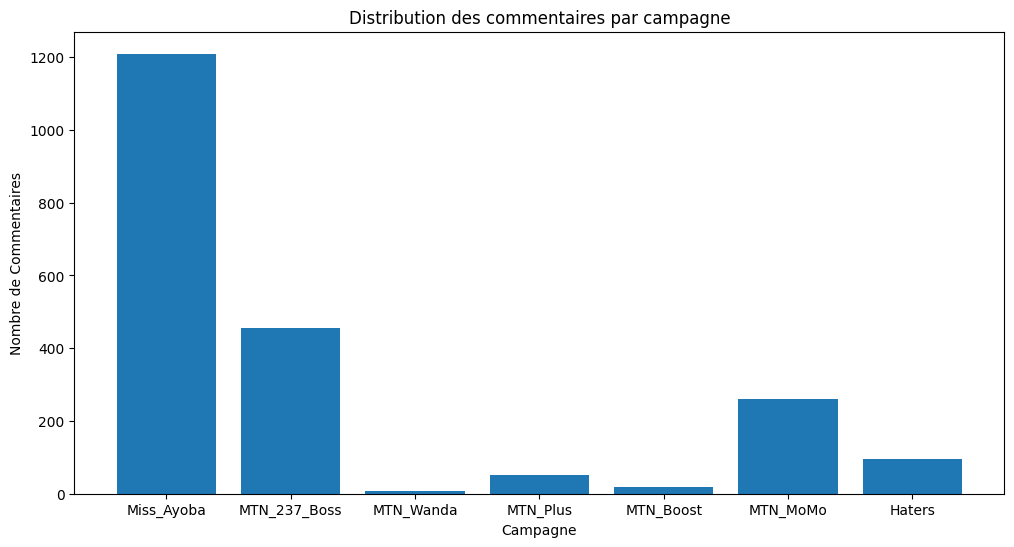

In [96]:
# Liste des noms de Campagne
campaigns_names = ['Miss_Ayoba', 'MTN_237_Boss','MTN_Wanda','MTN_Plus','MTN_Boost','MTN_MoMo','Haters']

# Calculer la distribution de chaque Campagne en nombre
campaigns_counts = Fb_Comments_df[campaigns_names].sum()

# Créer un graphique à barres pour la distribution de chaque Campagne
plt.figure(figsize=(12, 6))
plt.bar(campaigns_names, campaigns_counts)
plt.title('Distribution des commentaires par campagne')
plt.xlabel('Campagne')
plt.ylabel('Nombre de Commentaires')
plt.show()

In [97]:
# Initialiser un DataFrame vide pour les résultats
results_df = pd.DataFrame(columns=['Campagne', 'Moyenne Polarity', 'Max Polarity', 'Min Polarity', 'Médiane Polarity'])
# Liste des noms de Campagne
#campaigns_names = ['Miss_Ayoba', 'MTN_237_Boss']

# Parcourir les Campagne
for campaign in campaigns_names:
    # Filtrer le DataFrame pour une Campagne spécifique
    filtered_df = Fb_Comments_df[Fb_Comments_df[campaign] == 1]

    # Calculer les statistiques pour la polarité et la subjectivité
    polarity_stats = filtered_df['polarity'].agg(['mean', 'max', 'min', 'median'])

    # Ajouter les résultats au DataFrame des résultats using pd.concat
    # Create a temporary DataFrame for the new row
    new_row_df = pd.DataFrame([{
        'Campagne': campaign,
        'Moyenne Polarity': polarity_stats['mean'],
        'Max Polarity': polarity_stats['max'],
        'Min Polarity': polarity_stats['min'],
        'Médiane Polarity': polarity_stats['median'],
    }])
    # Concatenate the new row DataFrame with the results DataFrame
    results_df = pd.concat([results_df, new_row_df], ignore_index=True)


# Afficher le DataFrame des résultats
results_df

<ipython-input-97-960475b95994>:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row_df], ignore_index=True)


,Campagne,Moyenne Polarity,Max Polarity,Min Polarity,Médiane Polarity
0,Miss_Ayoba,0.043686,0.999608,-0.999977,0.581554
1,MTN_237_Boss,-0.154068,0.999876,-0.999872,-0.774935
2,MTN_Wanda,-0.256928,0.999636,-0.999949,-0.713171
3,MTN_Plus,0.324352,0.999736,-0.999977,0.977233
4,MTN_Boost,0.746612,0.999540,-0.962412,0.990396
5,MTN_MoMo,0.098479,0.999906,-0.999990,0.668883
6,Haters,-0.641222,0.998867,-0.999750,-0.998421


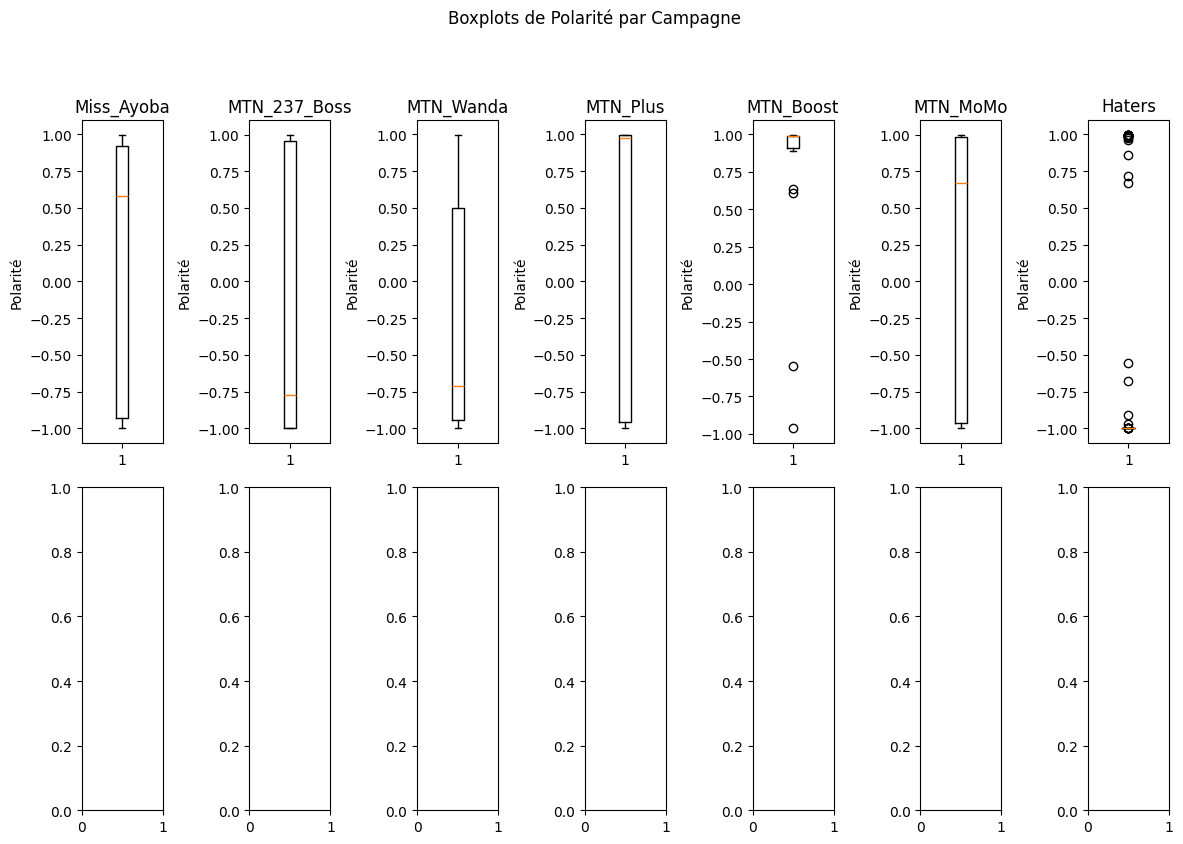

In [102]:
# Création des boxplots pour la polarité et la subjectivité pour chaque Campagne
fig, axes = plt.subplots(nrows=2, ncols=len(campaigns_names), figsize=(12, 8))

for i, campaign in enumerate(campaigns_names):
    # Boxplot de la polarité pour le Campagne spécifique
    axes[0, i].boxplot(Fb_Comments_df[Fb_Comments_df[campaign] == 1]['polarity'])
    axes[0, i].set_title(campaign)
    axes[0, i].set_ylabel('Polarité')

# Ajouter des titres et ajuster les espacements
fig.suptitle('Boxplots de Polarité par Campagne', y=1.05)
plt.tight_layout()

# Afficher les boxplots
plt.show()

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


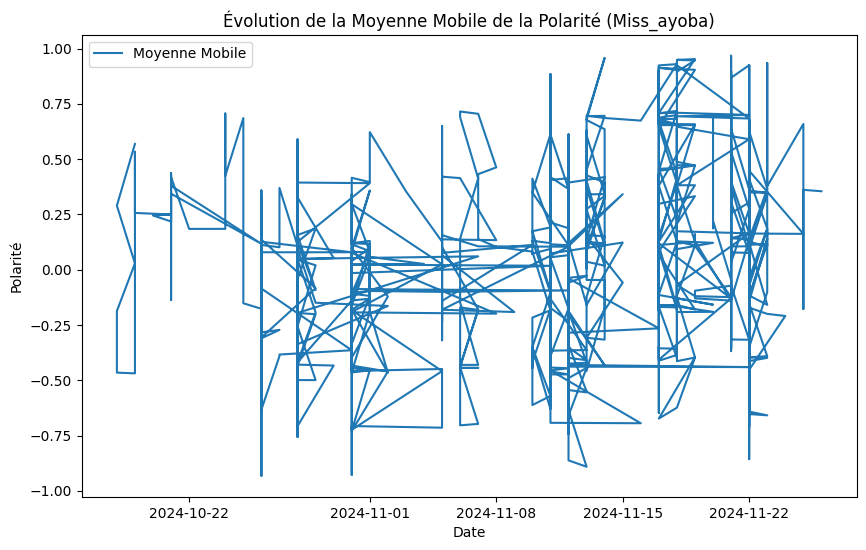

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


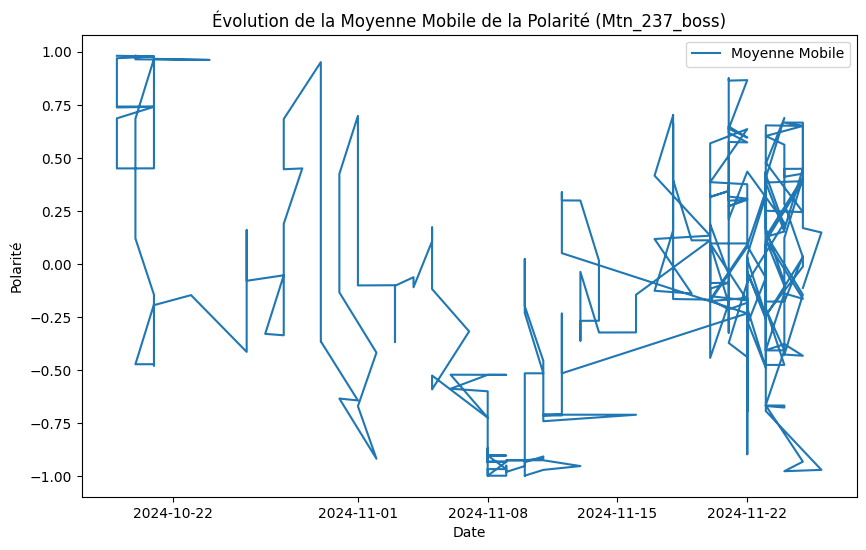

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


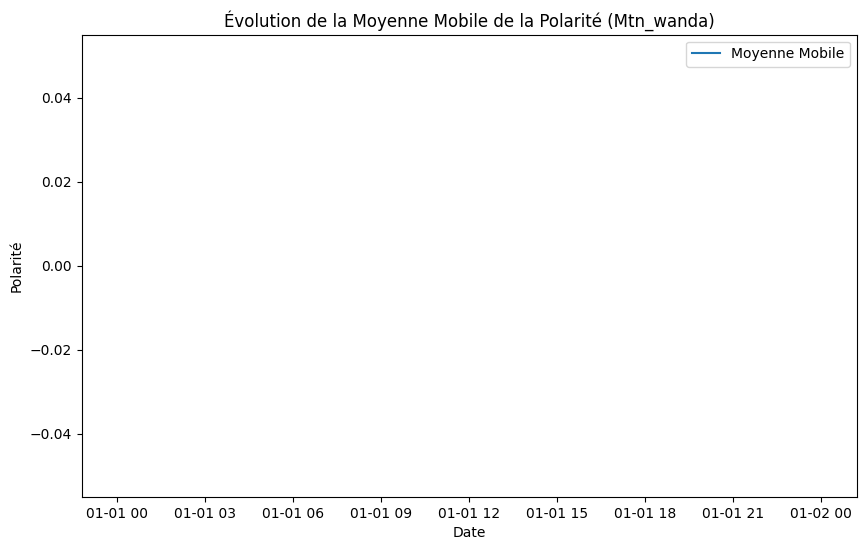

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


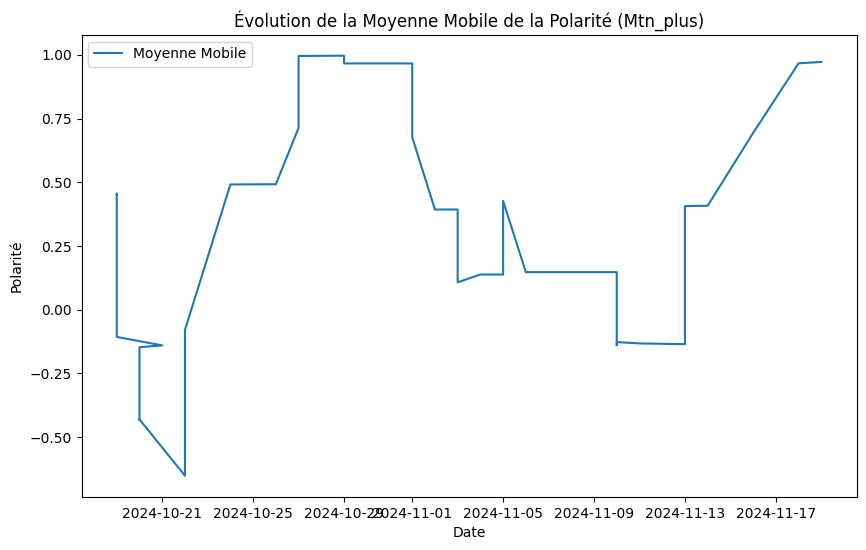

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


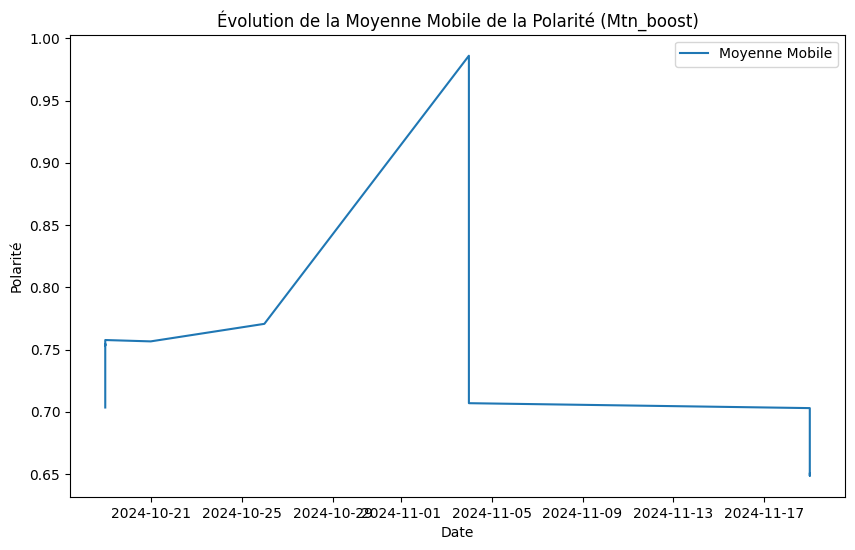

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


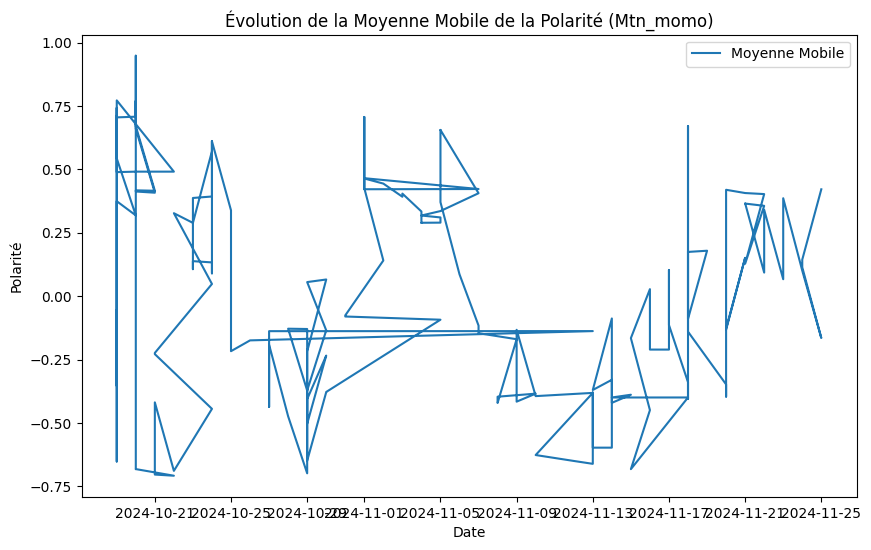

<ipython-input-103-d93d3fb3fc62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()


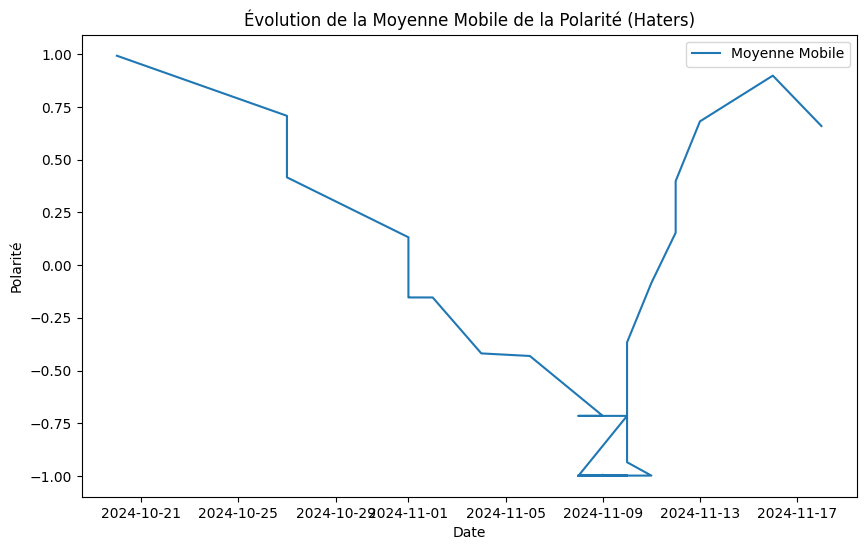

In [103]:
### Création des graphiques de l'évolution de la moyenne mobile de la polarité pour chaque campagne.
def plot_polarity_evolution(df, campaigns_names):
    for campaign in campaigns_names:
        # Filtrer les données pour la campaign actuel
        df_campaign = df[df[campaign] == 1]

        # Calculer la moyenne mobile (ajuster la fenêtre si nécessaire)
        df_campaign['polarity_rolling'] = df_campaign['polarity'].rolling(window=7).mean()

        # Créer la figure
        plt.figure(figsize=(10, 6))

        # Tracer la ligne de la moyenne mobile
        plt.plot(df_campaign['date'], df_campaign['polarity_rolling'], label='Moyenne Mobile')

        # Ajouter un titre et des étiquettes d'axes
        plt.title(f'Évolution de la Moyenne Mobile de la Polarité ({campaign.capitalize()})')
        plt.xlabel('Date')
        plt.ylabel('Polarité')

        # Afficher la légende
        plt.legend()

        # Afficher le graphique
        plt.show()

# Exemple d'utilisation :
# Supposons que vous ayez un DataFrame nommé 'df' et une liste de campagnes 'campaigns_names'
plot_polarity_evolution(Fb_Comments_df, campaigns_names)